In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Gathering

In [2]:
df = pd.read_csv('prosperLoanData.csv')

## Assessing and Cleaning

In [3]:
df.head(2)

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.158,0.138,...,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.092,0.082,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1


#### Define

The DataFrame in its current form contains 81 rows, many of which contain data I'm not particularly interested in for this project. I'll therefore only keep 18 columns, and give them more appropriate names them.

#### Code

In [4]:
# define columns I want to keep
df = df[['ListingNumber', 'ListingCreationDate', 'LoanOriginalAmount', 'LoanStatus', 'CreditGrade', 'ProsperRating (numeric)',\
         'BorrowerAPR', 'LenderYield', 'IncomeRange', 'StatedMonthlyIncome', 'IncomeVerifiable', 'MonthlyLoanPayment',\
         'DebtToIncomeRatio', 'IsBorrowerHomeowner', 'Occupation', 'EmploymentStatus', 'EmploymentStatusDuration',\
         'BorrowerState']]

In [5]:
# rename columns
df.columns = ['id', 'date', 'loan_amount', 'status', 'credit_grade', 'prosper_score', 'borrower_apr', 'lender_yield',\
              'income_range', 'monthly_income', 'income_verifiable', 'monthly_loan_payment', 'debt_ratio', 'homeowner',\
              'occupation', 'employment_status', 'employment_status_duration', 'homestate']

#### Test

In [6]:
df.head(2)

,id,date,loan_amount,status,credit_grade,prosper_score,borrower_apr,lender_yield,income_range,monthly_income,income_verifiable,monthly_loan_payment,debt_ratio,homeowner,occupation,employment_status,employment_status_duration,homestate
0,193129,2007-08-26 19:09:29.263000000,9425,Completed,C,NaN,0.16516,0.138,"$25,000-49,999",3083.333333,True,330.43,0.17,True,Other,Self-employed,2.0,CO
1,1209647,2014-02-27 08:28:07.900000000,10000,Current,NaN,6.0,0.12016,0.082,"$50,000-74,999",6125.000000,True,318.93,0.18,False,Professional,Employed,44.0,CO


#### Define

The column ``credit_grade`` contains prospers credit ratings prior to 2009, the column ``prosper_score`` contains credit ratings applicable to loans after 2009. I want to combine both columns into one column containing the credit rating for both periods. The alphanumerical rating of the ``credit_grade`` grade column can be encoded as follows: 0 - N/A, 1 - HR, 2 - E, 3 - D, 4 - C, 5 - B, 6 - A, 7 - AA. 

#### Code

In [7]:
# encode credit_grade column
df.credit_grade = df.credit_grade.map({'HR': 1, 'E': 2, 'D': 3, 'C': 4, 'B': 5, 'A': 6, 'AA': 7})

# replace all NaN values with 0 so both columns can be added
df[['credit_grade', 'prosper_score']] = df[['credit_grade', 'prosper_score']].fillna(0)

# create new column credit_rating which is the sum of credit_grade and prosper_score.
df['credit_rating'] = df.credit_grade + df.prosper_score

# drop old columns
df.drop(columns = ['credit_grade', 'prosper_score'], axis = 1, inplace = True)

#### Test

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 17 columns):
id                            113937 non-null int64
date                          113937 non-null object
loan_amount                   113937 non-null int64
status                        113937 non-null object
borrower_apr                  113912 non-null float64
lender_yield                  113937 non-null float64
income_range                  113937 non-null object
monthly_income                113937 non-null float64
income_verifiable             113937 non-null bool
monthly_loan_payment          113937 non-null float64
debt_ratio                    105383 non-null float64
homeowner                     113937 non-null bool
occupation                    110349 non-null object
employment_status             111682 non-null object
employment_status_duration    106312 non-null float64
homestate                     108422 non-null object
credit_rating                 113937 non-

#### Define

There are rows which contain no value for the borrower_apr (average percentage rate). As this is one key metric, I'm going to drop all rows which contain NaN for borrower_apr.

#### Code

In [9]:
df.dropna(subset = ['borrower_apr'], inplace = True)

#### Test

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113912 entries, 0 to 113936
Data columns (total 17 columns):
id                            113912 non-null int64
date                          113912 non-null object
loan_amount                   113912 non-null int64
status                        113912 non-null object
borrower_apr                  113912 non-null float64
lender_yield                  113912 non-null float64
income_range                  113912 non-null object
monthly_income                113912 non-null float64
income_verifiable             113912 non-null bool
monthly_loan_payment          113912 non-null float64
debt_ratio                    105358 non-null float64
homeowner                     113912 non-null bool
occupation                    110349 non-null object
employment_status             111682 non-null object
employment_status_duration    106312 non-null float64
homestate                     108422 non-null object
credit_rating                 113912 non-

#### Define

I want to introduce one more column ``bank_yield``. The bank yield is the difference between the borrowers APR and the lenders yield (the lenders interest rate) and thus provides information about prospers share on each deal. 

Then, reorder the columns so the rating and bank_yield are not at the very end.

#### Code

In [11]:
df['bank_yield'] = df['borrower_apr'] - df['lender_yield']

In [12]:
cols = df.columns.tolist()
cols

['id',
 'date',
 'loan_amount',
 'status',
 'borrower_apr',
 'lender_yield',
 'income_range',
 'monthly_income',
 'income_verifiable',
 'monthly_loan_payment',
 'debt_ratio',
 'homeowner',
 'occupation',
 'employment_status',
 'employment_status_duration',
 'homestate',
 'credit_rating',
 'bank_yield']

In [13]:
cols = ['id', 'date', 'status', 'loan_amount', 'credit_rating', 'borrower_apr', 'lender_yield', 'bank_yield',\
        'income_range','monthly_income', 'income_verifiable', 'monthly_loan_payment', 'debt_ratio', 'homeowner',\
        'occupation', 'employment_status', 'employment_status_duration', 'homestate']

df = df[cols]

#### Test

In [14]:
df.head(2)

,id,date,status,loan_amount,credit_rating,borrower_apr,lender_yield,bank_yield,income_range,monthly_income,income_verifiable,monthly_loan_payment,debt_ratio,homeowner,occupation,employment_status,employment_status_duration,homestate
0,193129,2007-08-26 19:09:29.263000000,Completed,9425,4.0,0.16516,0.138,0.02716,"$25,000-49,999",3083.333333,True,330.43,0.17,True,Other,Self-employed,2.0,CO
1,1209647,2014-02-27 08:28:07.900000000,Current,10000,6.0,0.12016,0.082,0.03816,"$50,000-74,999",6125.000000,True,318.93,0.18,False,Professional,Employed,44.0,CO


#### Define

There are 8669 occasions where the borrower can not verify the stated monthly income. As this makes it impossible to assess whether those values are indeed valid or not, I'm going to drop those rows.

In [15]:
df.income_verifiable.value_counts()

True     105243
False      8669
Name: income_verifiable, dtype: int64

#### Code

In [16]:
df = df[df['income_verifiable'] == True]

#### Test

In [17]:
df.income_verifiable.unique()

array([ True])

#### Define

- Change dtype of ``id`` to str
- Change dtype of ``date`` to datetime
- Change dtype of ``monthly_income`` to int (I'm fine with rounding here)
- Change dtype of ``monthly_loan_payment`` to int (I'm fine with rounding here)

#### Code

In [18]:
df.id = df.id.astype(str)
df.date = pd.to_datetime(df.date, yearfirst = True).dt.normalize()
df.monthly_income = df.monthly_income.astype(int)
df.monthly_loan_payment = df.monthly_loan_payment.astype(int)

#### Test

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105243 entries, 0 to 113936
Data columns (total 18 columns):
id                            105243 non-null object
date                          105243 non-null datetime64[ns]
status                        105243 non-null object
loan_amount                   105243 non-null int64
credit_rating                 105243 non-null float64
borrower_apr                  105243 non-null float64
lender_yield                  105243 non-null float64
bank_yield                    105243 non-null float64
income_range                  105243 non-null object
monthly_income                105243 non-null int32
income_verifiable             105243 non-null bool
monthly_loan_payment          105243 non-null int32
debt_ratio                    105078 non-null float64
homeowner                     105243 non-null bool
occupation                    101719 non-null object
employment_status             103052 non-null object
employment_status_duration    97764

In [20]:
df.head()

,id,date,status,loan_amount,credit_rating,borrower_apr,lender_yield,bank_yield,income_range,monthly_income,income_verifiable,monthly_loan_payment,debt_ratio,homeowner,occupation,employment_status,employment_status_duration,homestate
0,193129,2007-08-26,Completed,9425,4.0,0.16516,0.1380,0.02716,"$25,000-49,999",3083,True,330,0.17,True,Other,Self-employed,2.0,CO
1,1209647,2014-02-27,Current,10000,6.0,0.12016,0.0820,0.03816,"$50,000-74,999",6125,True,318,0.18,False,Professional,Employed,44.0,CO
2,81716,2007-01-05,Completed,3001,1.0,0.28269,0.2400,0.04269,Not displayed,2083,True,123,0.06,False,Other,Not available,NaN,GA
3,658116,2012-10-22,Current,10000,6.0,0.12528,0.0874,0.03788,"$25,000-49,999",2875,True,321,0.15,True,Skilled Labor,Employed,113.0,GA
4,909464,2013-09-14,Current,15000,3.0,0.24614,0.1985,0.04764,"$100,000+",9583,True,563,0.26,True,Executive,Employed,44.0,MN


#### Define

Check the monthly income for plausibility

#### Code

In [21]:
df.monthly_income.describe()

count    105243.000000
mean       5654.810496
std        4937.070098
min           0.000000
25%        3333.000000
50%        4750.000000
75%        6845.500000
max      483333.000000
Name: monthly_income, dtype: float64

In [22]:
df.loc[df.monthly_income.nlargest(5).index]

,id,date,status,loan_amount,credit_rating,borrower_apr,lender_yield,bank_yield,income_range,monthly_income,income_verifiable,monthly_loan_payment,debt_ratio,homeowner,occupation,employment_status,employment_status_duration,homestate
17411,501462,2011-04-08,Completed,7500,2.0,0.35643,0.3099,0.04653,"$100,000+",483333,True,326,0.00,True,Professional,Employed,121.0,HI
57133,499194,2011-03-24,Current,4000,2.0,0.35643,0.3099,0.04653,"$100,000+",466666,True,174,0.00,True,Other,Employed,271.0,CT
8066,500651,2011-04-02,Completed,2000,1.0,0.35643,0.3099,0.04653,"$100,000+",416666,True,87,0.00,True,Police Officer/Correction Officer,Employed,183.0,IL
113270,715718,2013-02-20,Current,2000,4.0,0.22712,0.1799,0.04722,"$100,000+",394400,True,73,0.00,False,Other,Employed,173.0,CA
8870,66246,2006-11-26,Chargedoff,12500,6.0,0.12700,0.1050,0.02200,Not displayed,208333,True,415,0.01,True,Other,Not available,NaN,CT


#### Issue

There are several individuals who specify a 6-figure monthly income with a debt to income ratio of near 0 and yet still receive incredibly bad credit ratings and borrow money at an APR of 35%. I don't believe those values to be valid. I therefore considered to only include the 99 quantile monthly income in the dataset.

#### Code

In [23]:
quantile95 = df.monthly_income.quantile(.99)

In [24]:
df = df[df['monthly_income'] < quantile95]

## Analyzing and Visualizing

### Univariate Data Exploration

In [25]:
base_color = '#708090'

#### What timeframe does the dataset cover?

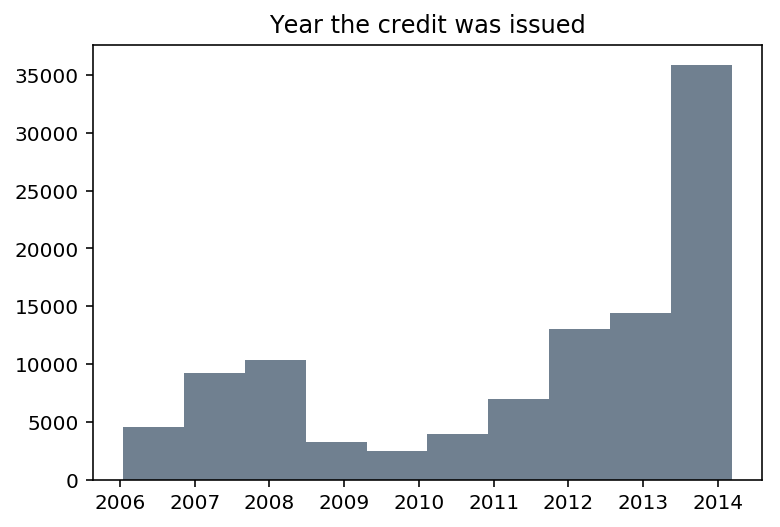

In [26]:
plt.hist(df.date, color = base_color)
plt.title('Year the credit was issued');

The dataset contains data for transactions from 2006 up to 2014, with 2014 making up the greatest proportion.

#### What is the distribution of the monthly income?

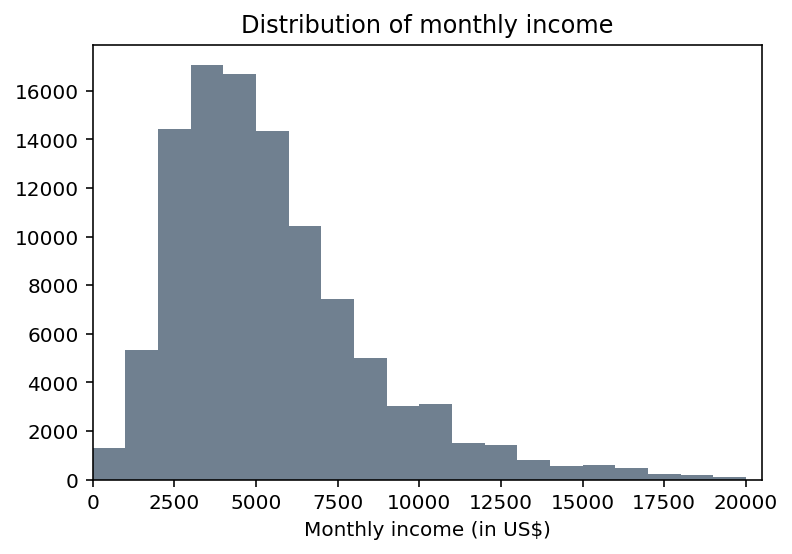

In [27]:
plt.hist(df.monthly_income, bins = np.arange(0, 20500 + 1000, 1000), color = base_color)
plt.xlim(0, 20500)
plt.title('Distribution of monthly income')
plt.xlabel('Monthly income (in US$)');

Most individuals obtain a monthly income between 2500 and 7500 US$.

#### What is the distribution of the loan amount?

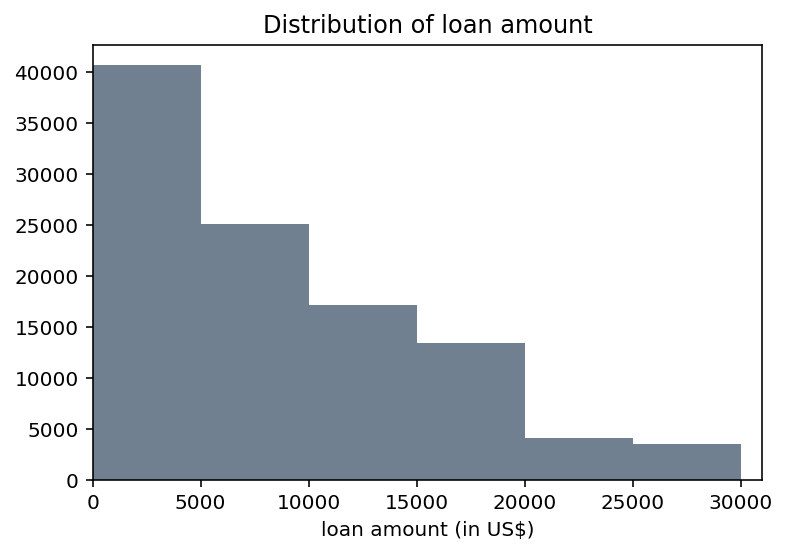

In [28]:
plt.hist(df.loan_amount, bins = np.arange(0, 30000 + 1000, 5000), color = base_color)
plt.xlim(0, 30000 + 1000)
plt.title('Distribution of loan amount')
plt.xlabel('loan amount (in US$)');

The plot of the loan amount is right skewed with most loans being less than 5,000 US$.

#### What are the propabilities for a loan to defaulted or be chargedoff?

In [29]:
outcome_df = df[df['status'].isin(['Completed', 'Chargedoff', 'Defaulted'])]

n = outcome_df.status.count()
n_max = outcome_df.status.value_counts().max()
p_max = n_max / n
ticks = np.arange(0, p_max + 0.1, 0.1)
labels = ['{:.1f}'.format(v) for v in ticks]
order = outcome_df.status.value_counts().index

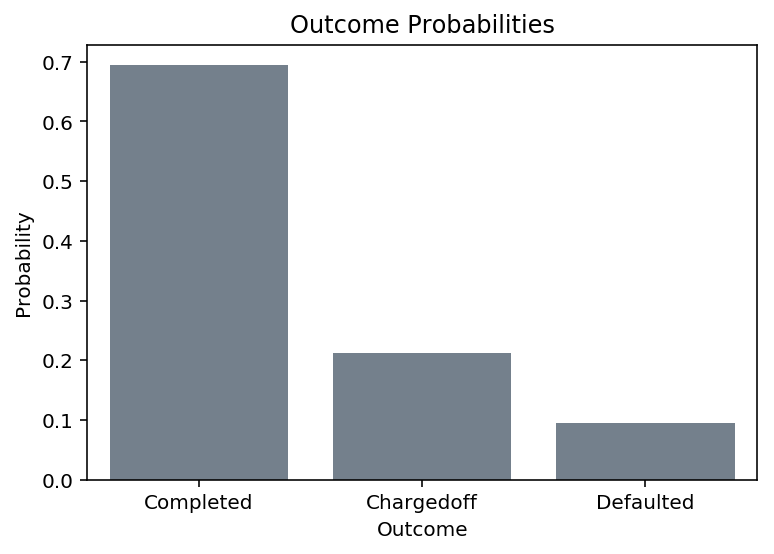

In [30]:
sns.countplot(outcome_df.status, color = base_color, order = order)
plt.yticks(ticks * n, labels)
plt.title('Outcome Probabilities')
plt.ylabel('Probability')
plt.xlabel('Outcome');

The probability of a loan to be payed back is 70%. 20% of all loans get charged off and 10% of all loans default.

### Bivariate Exploration

#### How do the borrowers APR and the lenders yield compare?

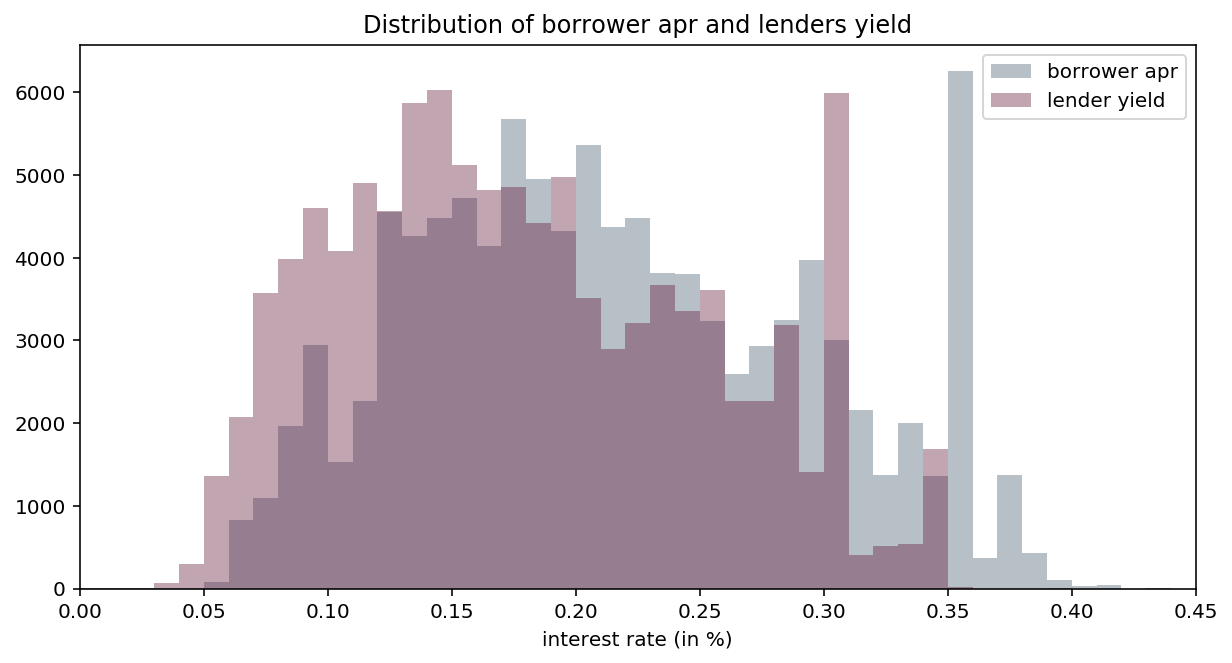

In [31]:
plt.figure(figsize = (10, 5))
plt.hist(df.borrower_apr, bins = np.arange(0, 0.5, 0.01), color = '#708090', alpha = 0.5)
plt.hist(df.lender_yield, bins = np.arange(0, 0.5, 0.01), color = '#651e3e', alpha = 0.4)
plt.legend(['borrower apr', 'lender yield'])
plt.xlim(0, 0.45)
plt.title('Distribution of borrower apr and lenders yield')
plt.xlabel('interest rate (in %)');

The distribution of the lenders yield is basically a left skewed borrowers apr curve. This makes sense with the difference between both variables being prospers share in the deal. Interestingly, theres a major elevation at the 0.35 mark for the borrower apr and the 0.30 mark for the lender yield.

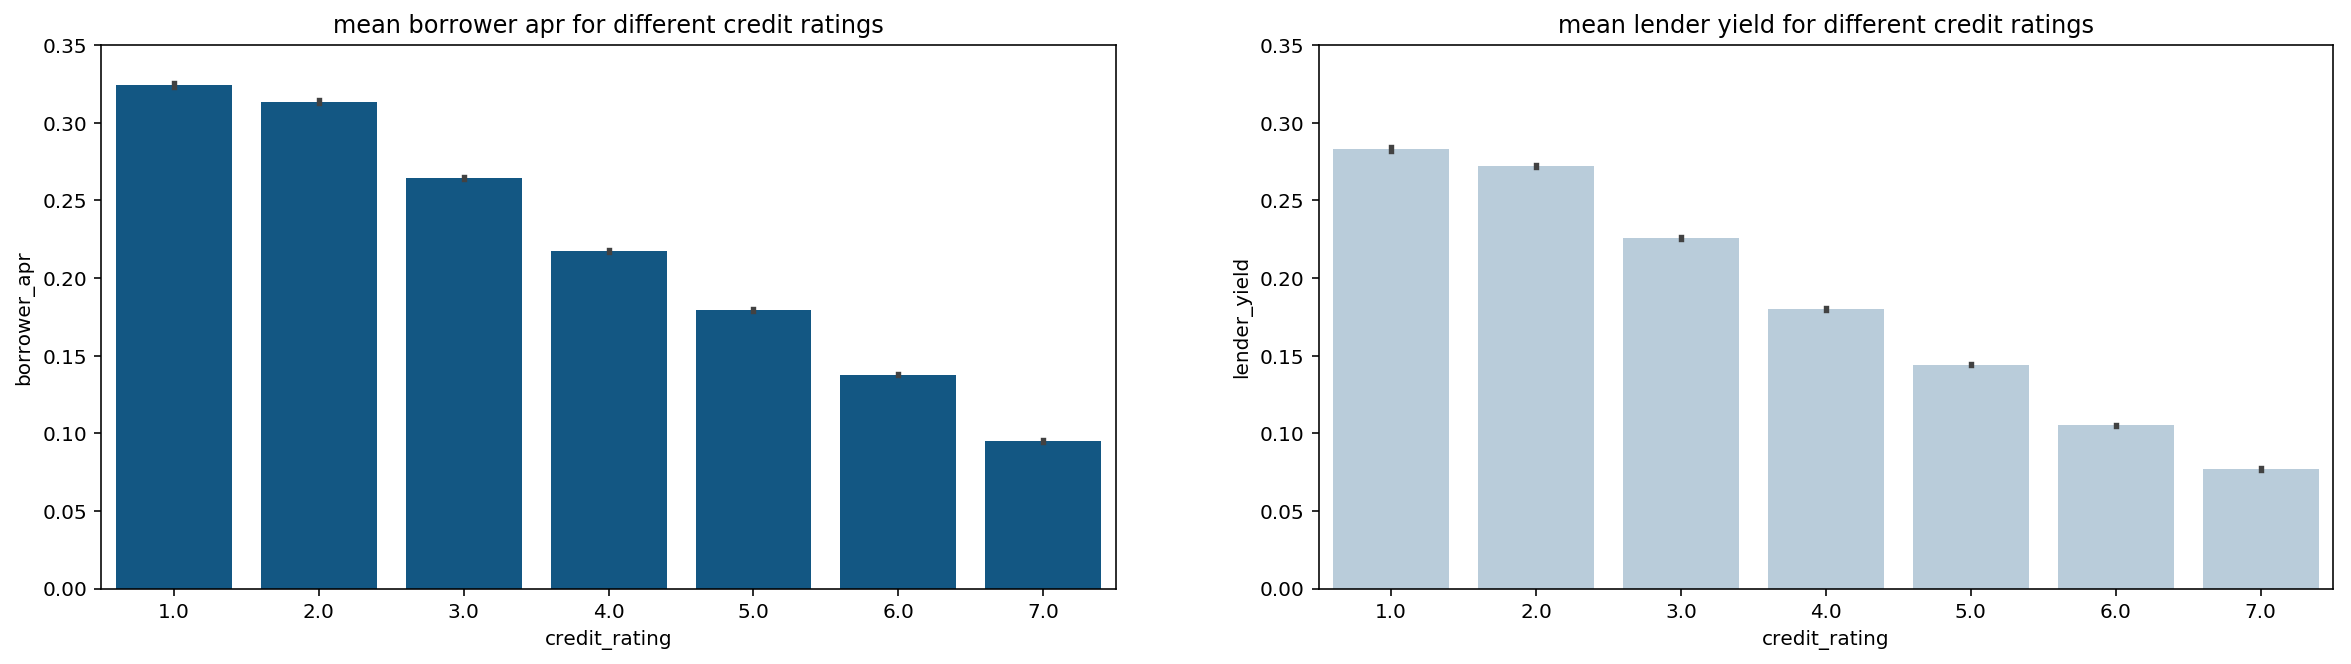

In [32]:
data = df[df['credit_rating'] != 0] # exclude credit rating of 0 (NaN)

plt.figure(figsize = (20, 5))

plt.subplot(1, 2, 1)
sns.barplot(data = data, x = 'credit_rating', y = 'borrower_apr', color = '#005b96')
plt.ylim([0, 0.35])
plt.title('mean borrower apr for different credit ratings')

plt.subplot(1, 2, 2)
sns.barplot(data = data, x = 'credit_rating', y = 'lender_yield', color = '#b3cde0')
plt.ylim([0, 0.35])
plt.title('mean lender yield for different credit ratings');

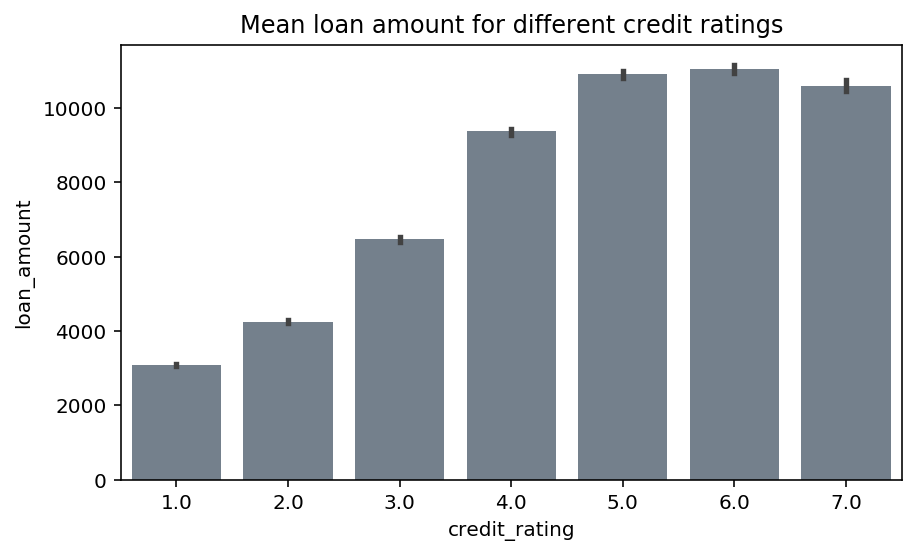

In [33]:
plt.figure(figsize = (7, 4))
sns.barplot(data = data, x = 'credit_rating', y = 'loan_amount', color = base_color)
plt.title('Mean loan amount for different credit ratings');

Interesting. Individuals with a lower credit rating tend to on average take lower loans. This effect however stops at a credit rating of 5 where the average loan amount does not increase any further.

#### What are the differences for different outcomes?

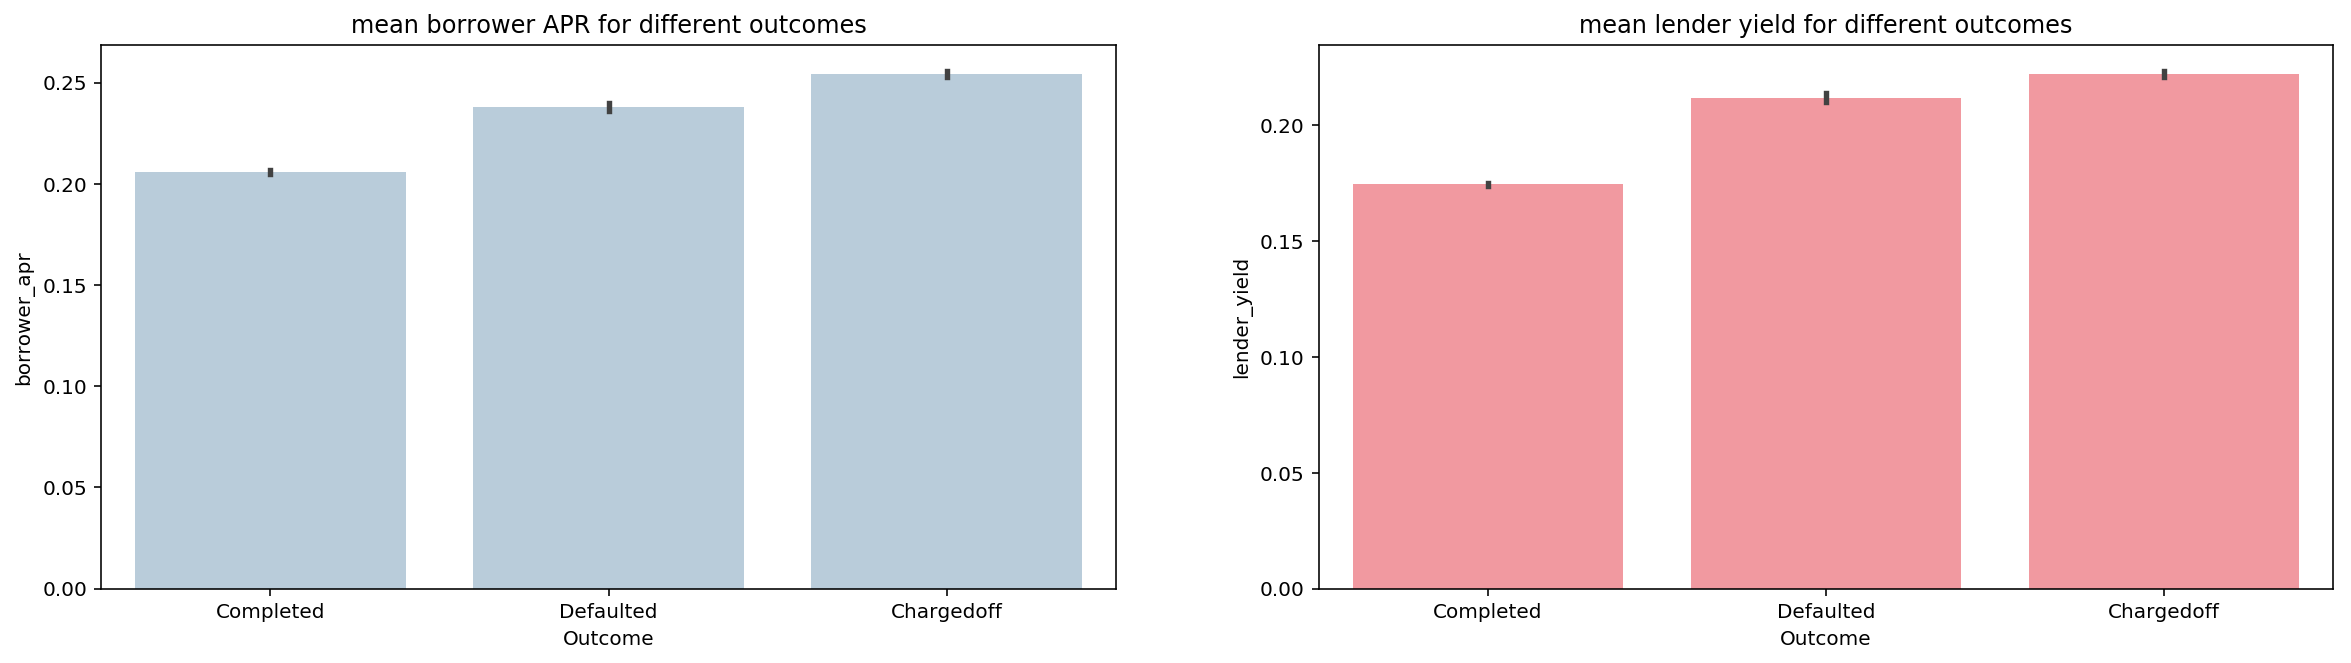

In [34]:
plt.figure(figsize = (20, 5))

plt.subplot(1, 2, 1)
sns.barplot(data = outcome_df, x = 'status', y = 'borrower_apr', color = '#b3cde0')
plt.title('mean borrower APR for different outcomes')
plt.xlabel('Outcome');

plt.subplot(1, 2, 2)
sns.barplot(data = outcome_df, x = 'status', y = 'lender_yield', color = '#ff8b94')
plt.title('mean lender yield for different outcomes')
plt.xlabel('Outcome');

#### How do the outcome probabilities compare for different credit ratings?

In [35]:
# Query the outcome df to only include the columns status and credit_rating
query = outcome_df[['status', 'credit_rating']]

# Exclude credit rating 0 (equivalent to NaN)
query = query[query['credit_rating'] != 0]

# groupby credit rating and status to get get a df with the count for each status
groupby_credit_rating = query.groupby(['credit_rating', 'status']).size().reset_index()
groupby_credit_rating.head()

,credit_rating,status,0
0,1.0,Chargedoff,2153
1,1.0,Completed,3202
2,1.0,Defaulted,1056
3,2.0,Chargedoff,1838
4,2.0,Completed,3736


In [36]:
# create lists which contain the values for each category for each rating 
completed = list(groupby_credit_rating.query('"Completed" in status')[0])
defaulted = list(groupby_credit_rating.query('"Defaulted" in status')[0])
chargedoff = list(groupby_credit_rating.query('"Chargedoff" in status')[0])

In [37]:
# construct a new df used for the stacked bar graph
raw_data = {'Completed': completed, 'Defaulted': defaulted, 'Chargedoff': chargedoff}
outcome_stacked = pd.DataFrame(raw_data)

In [38]:
# convert the values from absolute to percentage
totals = [i + j + k for i, j, k in zip(outcome_stacked['Completed'], outcome_stacked['Defaulted'],\
                                       outcome_stacked['Chargedoff'])]
Completed = [i / j * 100 for i, j in zip(outcome_stacked['Completed'], totals)]
Defaulted = [i / j * 100 for i, j in zip(outcome_stacked['Defaulted'], totals)]
Chargedoff = [i / j * 100 for i, j in zip(outcome_stacked['Chargedoff'], totals)]

r = [1, 2, 3, 4, 5, 6, 7]

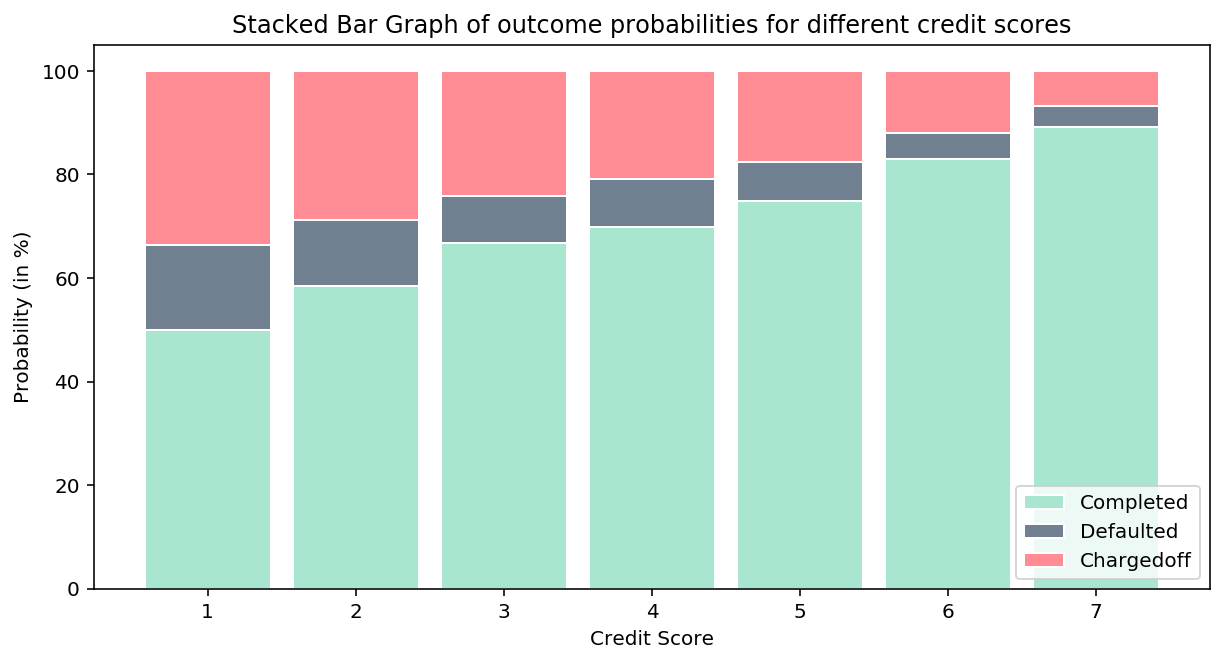

In [39]:
# plot the stacked bar graph
width = 0.85

plt.figure(figsize = (10, 5))

plt.bar(r, Completed, color = '#a8e6cf', edgecolor = 'white', width = width, label = 'Completed')
plt.bar(r, Defaulted, bottom = Completed, color = base_color, edgecolor = 'white', width = width, label = 'Defaulted')
plt.bar(r, Chargedoff, bottom = [i + j for i, j in zip(Completed, Defaulted)], color = '#ff8b94',\
        edgecolor = 'white', width = width, label = 'Chargedoff')

plt.title('Stacked Bar Graph of outcome probabilities for different credit scores')
plt.legend(loc = 'lower right')
plt.xlabel('Credit Score')
plt.ylabel('Probability (in %)');

Resource: [Stacked Bar Graph](https://python-graph-gallery.com/13-percent-stacked-barplot/)

#### Are homeowners offered a lower APR?

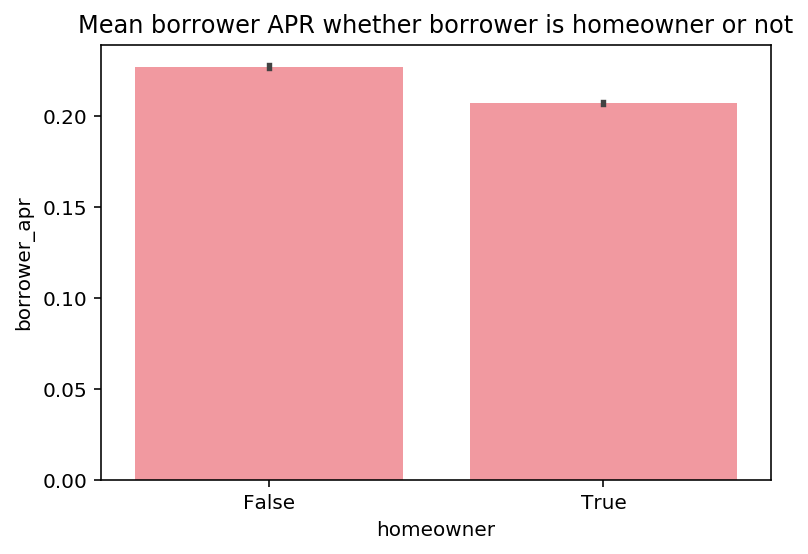

In [40]:
sns.barplot(data = df, x = 'homeowner', y = 'borrower_apr', color = '#ff8b94')
plt.title('Mean borrower APR whether borrower is homeowner or not');

A borrower who is already a homeowner gets on average a lower APR compared to a borrower not already owns a home.

#### Are there differences for the borrowers APR depending on the state he lives in?

Get a df which is grouped by state and sorted by the mean borrower APR in descending order:

In [41]:
homestate_df = df.groupby('homestate').mean().reset_index().sort_values('borrower_apr', ascending = False)
homestate_df.homestate.head().values

array(['AL', 'AR', 'SD', 'MS', 'NV'], dtype=object)

Color encode to highlight the 5 states with the on average highest borrower APR's:

In [42]:
clrs = ['#ff8b94' if (x in ['AL', 'AR', 'SD', 'MS', 'NV']) else '#b3cde0' for x in homestate_df.homestate]

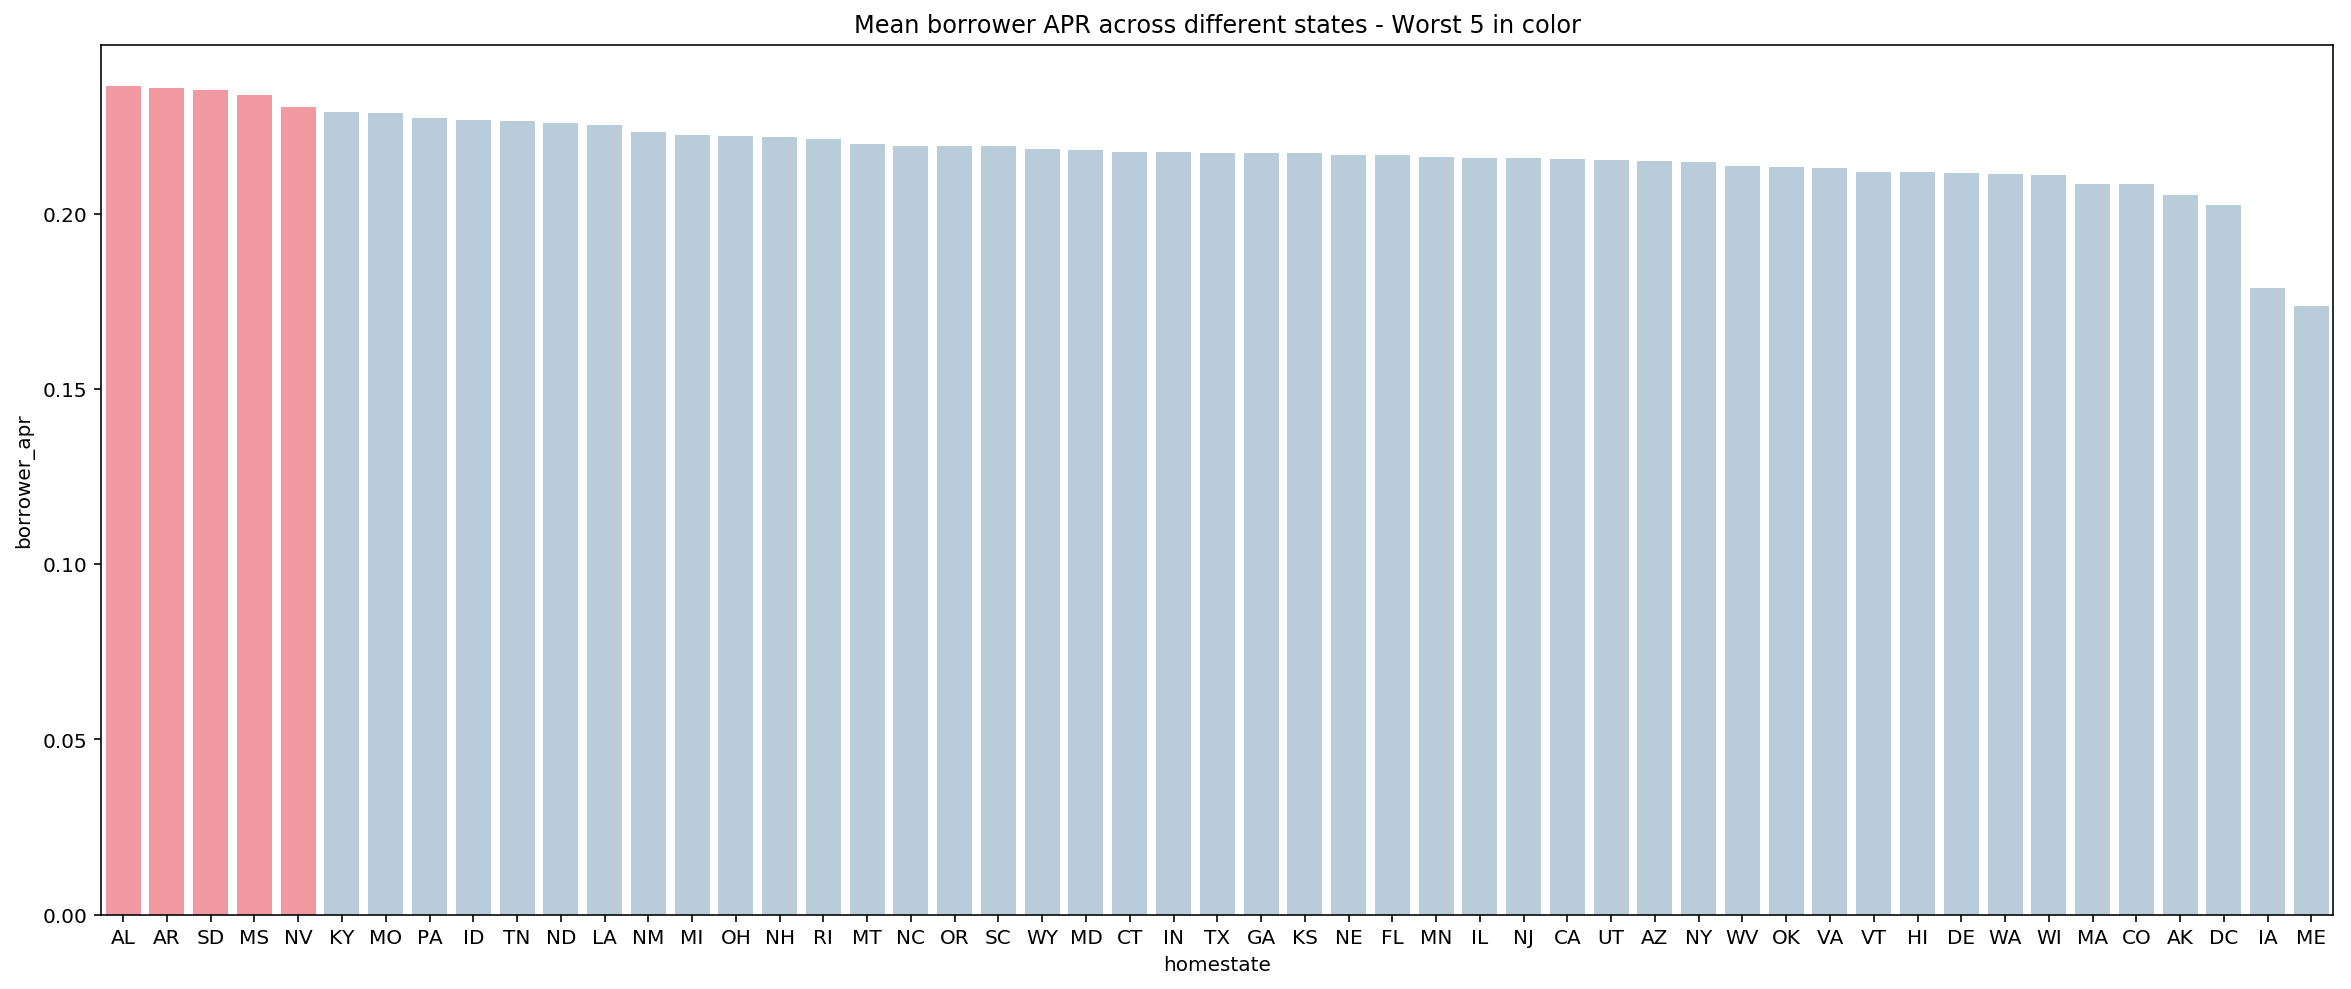

In [43]:
plt.figure(figsize = (20, 8))
sns.barplot(data = df, y = 'borrower_apr', x = 'homestate', order = homestate_df['homestate'], palette = clrs, ci = None)
plt.title('Mean borrower APR across different states - Worst 5 in color');

#### Are there differences for the borrowers APR regarding the borrowers occupation?

In [44]:
occupation_df = df.groupby('occupation').mean().reset_index().sort_values('borrower_apr', ascending = False)
occupation_list = list(occupation_df.occupation.tail())

In [45]:
clrs = ['#a8e6cf' if (x in occupation_list) else '#b3cde0' for x in occupation_df.occupation]

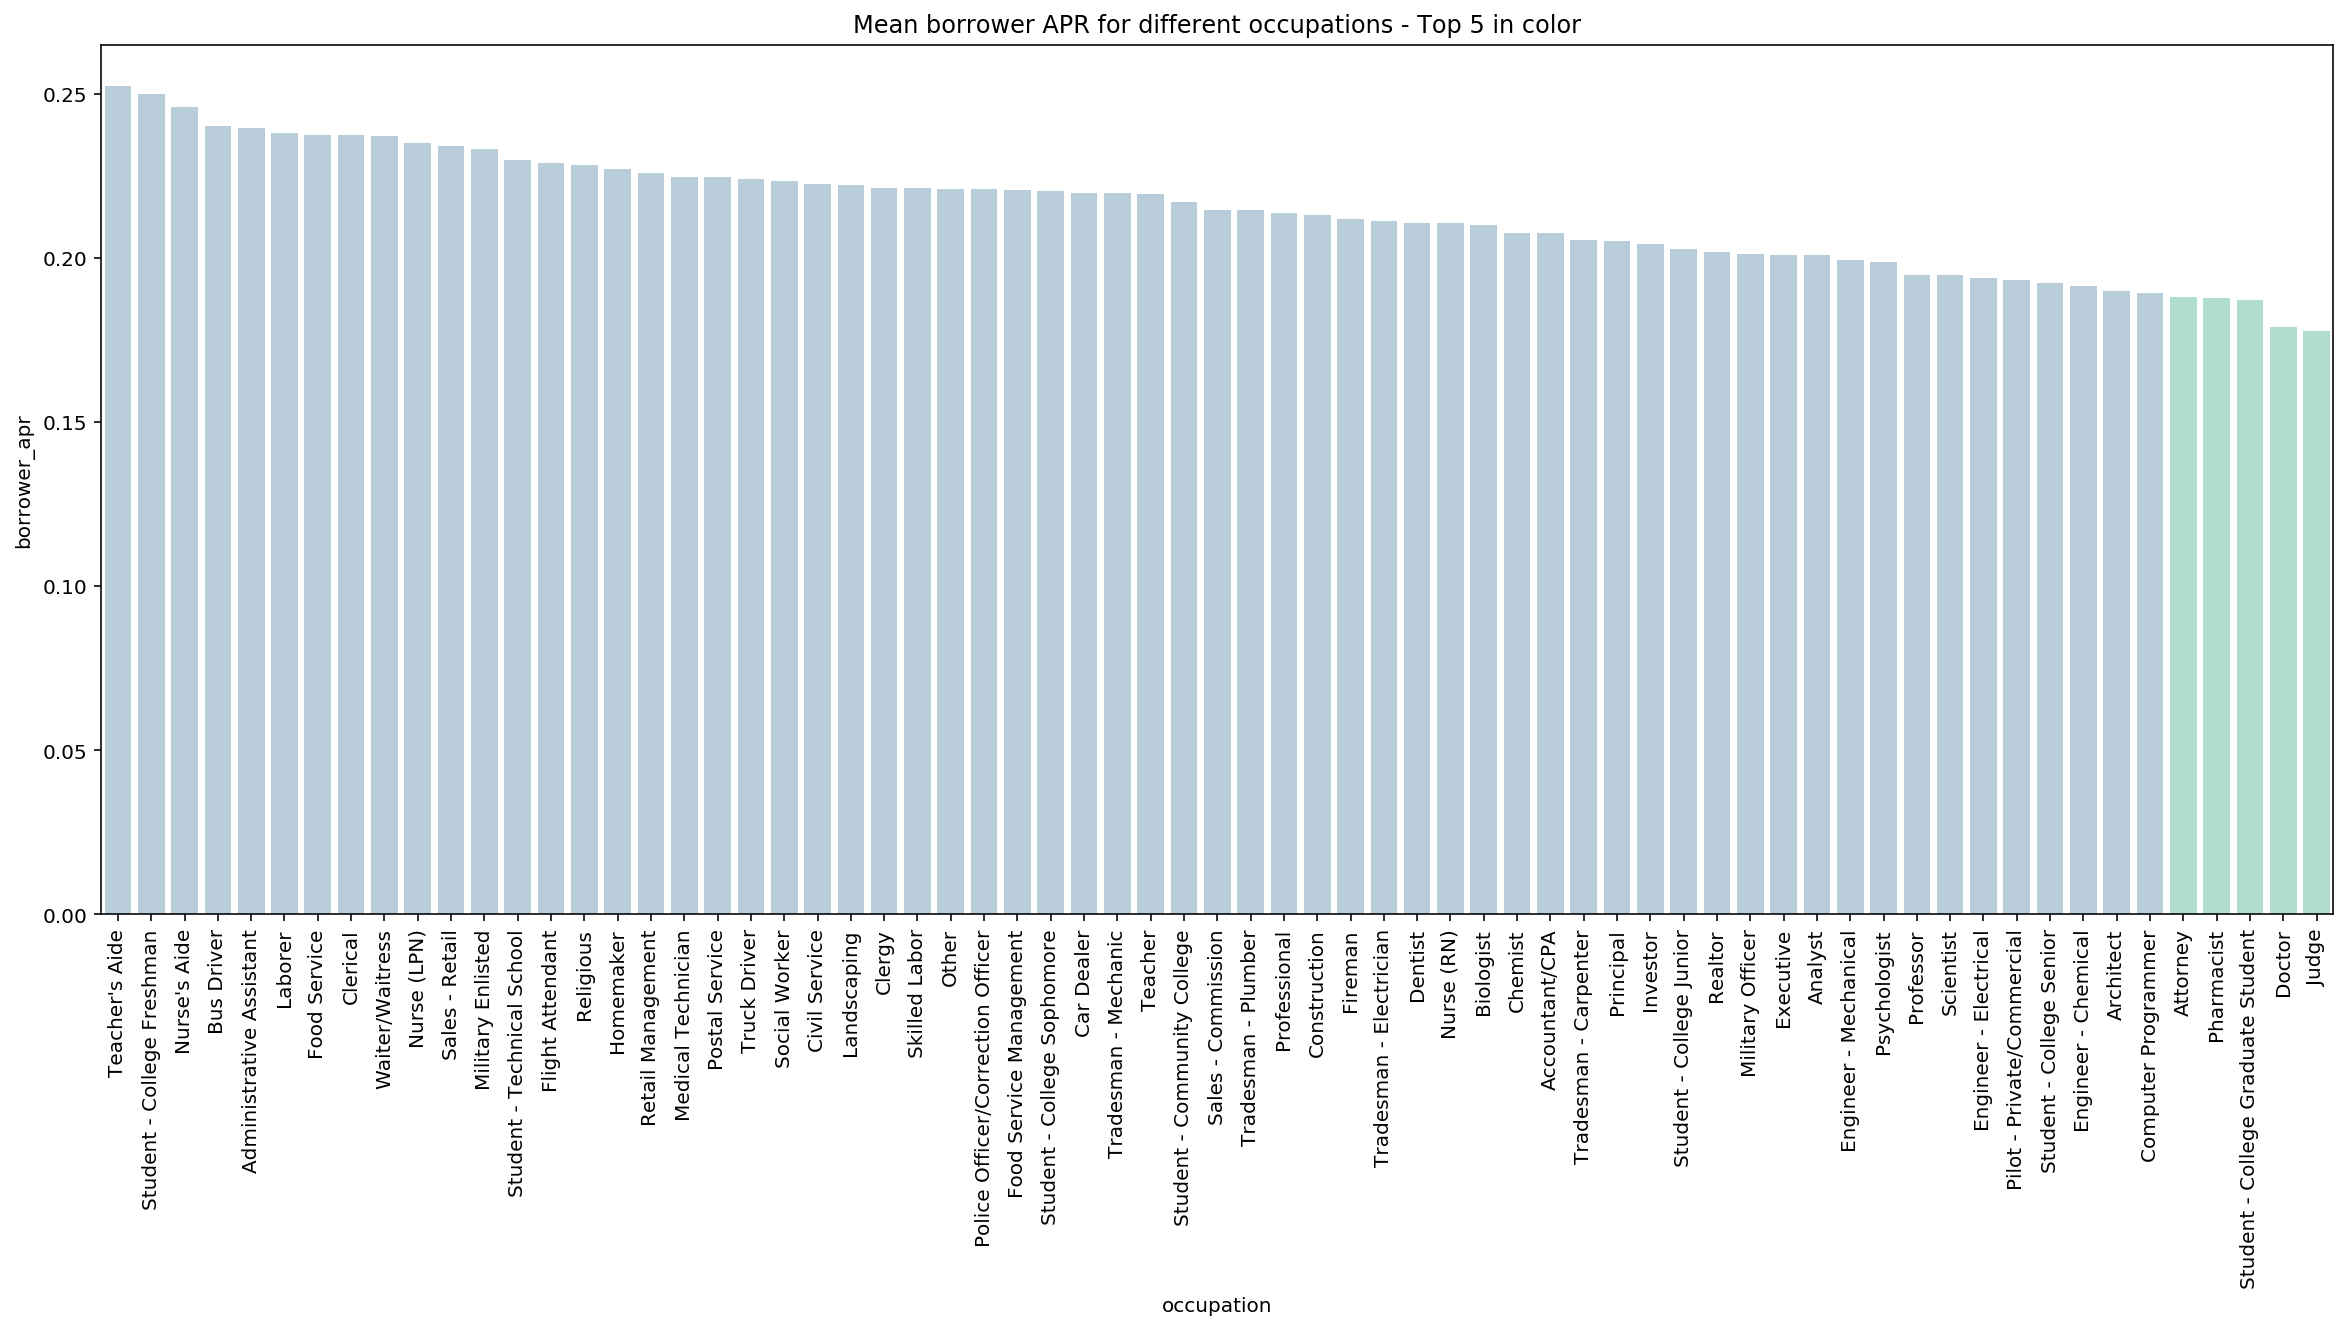

In [46]:
plt.figure(figsize = (20, 8))
sns.barplot(data = df, x = 'occupation', y = 'borrower_apr', order = occupation_df['occupation'], palette = clrs, ci = None)
plt.title('Mean borrower APR for different occupations - Top 5 in color')
plt.xticks(rotation = 90);

#### Development of different variables over time

In [47]:
groupby_year = df.groupby(df.date.dt.year).mean().reset_index()

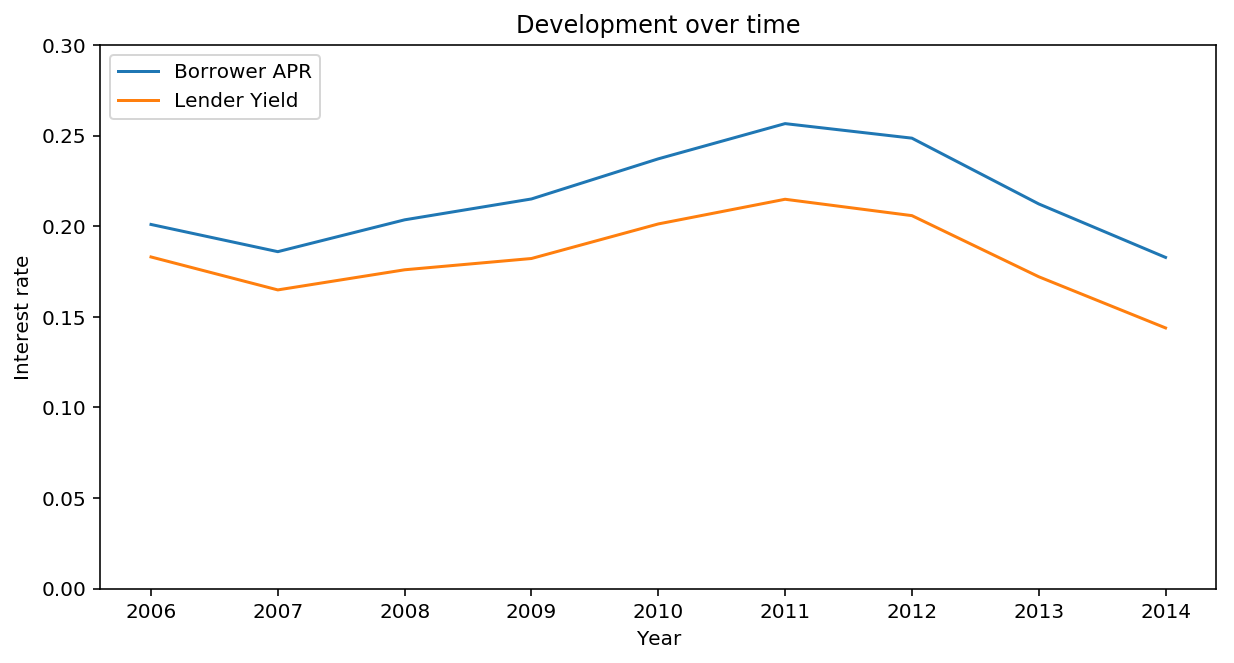

In [49]:
plt.figure(figsize = (10, 5))
plt.plot(groupby_year.date, groupby_year.borrower_apr)
plt.plot(groupby_year.date, groupby_year.lender_yield)
plt.ylim([0, 0.3])
plt.title('Development over time')
plt.xlabel('Year')
plt.ylabel('Interest rate')
plt.legend(['Borrower APR', 'Lender Yield'], loc = 'upper left');

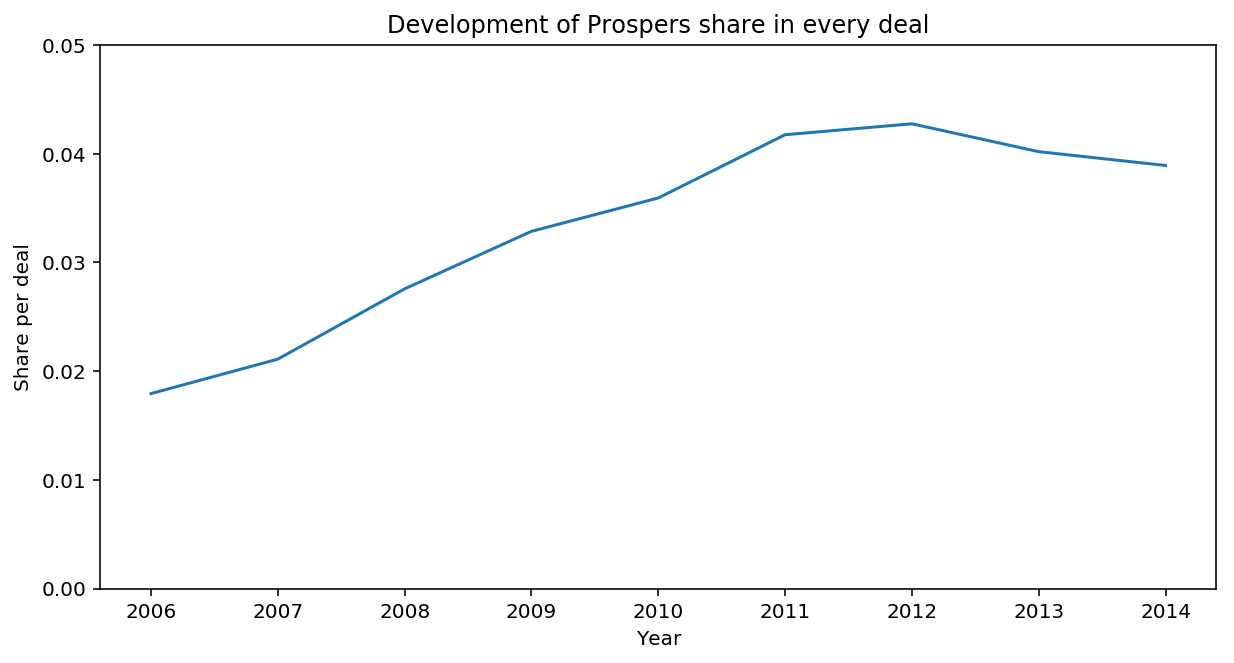

In [50]:
plt.figure(figsize = (10, 5))

plt.plot(groupby_year.date, groupby_year.bank_yield)
plt.ylim([0, 0.05])
plt.title('Development of Prospers share in every deal')
plt.xlabel('Year')
plt.ylabel('Share per deal');

Prospers share in every deal nearly doubled from 2% in 2006 to 4% in 2014 indicating a greater gap between the borrowers apr and the lenders yield.